# 1.Database

## 1.1

In [1]:
pixel = 92*112
print(pixel)

10304


There are 400 images in the database.
There are 10304 pixels in each image.

# 2.Presentation of the model

## 2.1

To prove it's not convex, we have an example.

We take $W1=[0]$, $W2=[1]$, $H1=[1]$, $H2=[0]$, $M=[0]$

So we calculate: $f(W1, H1) = 0$, $f(W2, H2) = 0$, $f(\frac{W1+W2}{2}, \frac{H1+H2}{2}) = \frac{1}{32}$

Because: $\frac{1}{2} * (f(W1, H1) + f(W2, H2)) \lt f(\frac{W1+W2}{2}, \frac{H1+H2}{2})$

So: it's not convex

# 3.Find W when H0 is fixed

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse.linalg import  svds
from numpy.linalg import norm
from skimage import img_as_float
import scipy.optimize
import scipy.sparse

## 3.1

In [3]:
def build_matrix_from_faces(folder='att_faces', minidata=False):
    # load images
    # 400 images of size (112, 92)
    M = []
    if minidata is True:
        nb_subjects = 1
    else:
        nb_subjects = 40
    for subject in range(1, nb_subjects + 1
                        ):
        for image in range(1, 11):
            face = plt.imread(folder + '/s' + str(subject)
                              + '/' + str(image) + '.pgm')
            M.append(face.ravel())

    return np.array(M, dtype=float)

def vectorize(W, H):
    return np.concatenate((W.ravel(), H.ravel()))

def unvectorize_M(W_H, M):
    # number of elements in W_H is (n+p)*k where M is of size n x m
    # W has the nk first elements
    # H has the kp last elements
    n, p = M.shape
    k = W_H.shape[0] // (n + p)
    W = W_H[:n * k].reshape((n, k))
    H = W_H[n * k:].reshape((k, p))
    return W, H

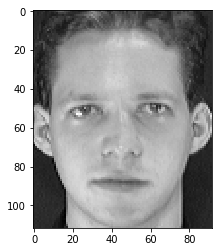

In [4]:
# Small data to test the algorithm
M = build_matrix_from_faces(folder='att_faces', minidata=True)
def unvectorize(W_H): return unvectorize_M(W_H, M)
k = 2
# To see the first face:
plt.imshow(M[0].reshape((112, 92)), cmap='gray'); plt.show()

In [23]:
# Full data
M = build_matrix_from_faces(folder='att_faces', minidata=False)
def unvectorize(W_H): return unvectorize_M(W_H, M)
k = 1
n, p = M.shape
W0, S, H0 = svds(M, k)
W0 = np.maximum(0, W0 * np.sqrt(S))
H0 = np.maximum(0,(H0.T * np.sqrt(S)).T)

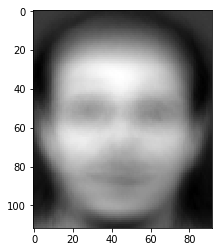

In [25]:
plt.imshow(H0[0].reshape((112, 92)), cmap='gray'); plt.show()

## 3.3

In [48]:
def val_g(W):
    return 1/(2*n*p)*norm(M-np.dot(W.reshape(-1,1), H0))**2

In [49]:
val_g(W0)

678.6096955506824

In [28]:
W0[0]

array([28.07684894])

In [44]:
def grad_g(W):
    return -1/(n*p)*np.dot((M-np.dot(W.reshape(-1,1), H0)), H0.T).reshape(-1)

In [53]:
grad_g(W0).shape

(400,)

In [50]:
scipy.optimize.check_grad(val_g, grad_g, W0.reshape(-1))

0.0001641649993293115

In [52]:
scipy.optimize.check_grad?

In [40]:
W0.reshape(-1).shape

(400,)

## 3.4

In [114]:
def l(x):
    if(x<0): 
        return inf
    else: 
        return 0    
L0 = norm(np.dot(H0.T, H0))/(n*p)

## 3.5

In [127]:
def projected_gradient_method(val_g, grad_g, W0, gamma, N):
    for i in range(N):
        W0 = W0-gamma*grad_g(W0)
        if (W0.any() < 0): W0 =  maximun(W0, 0)   
    return val_g(W0)   

## 3.6

In [128]:
projected_gradient_method(val_g, grad_g, W0, 1/L0, 100)

0.00597862147095094

## 4.1

In [172]:
W0, S, H0 = svds(M, k)
W0 = np.maximum(0, W0 * np.sqrt(S))
H0 = np.maximum(0,(H0.T * np.sqrt(S)).T)

In [174]:
b = 100
a = 0.3
l = 0
def taylor_based_line_search(val_g, grad_g, W0, b, a, l):
    Wplus = W0 - b*(a**l)*grad_g(W0)
    return val_g(W0) + np.prod(grad_g(W0) * (Wplus - W0)) + 1/(2*b*(a**l))*norm(W0 - Wplus)**2 - val_g(Wplus)
while(taylor_based_line_search(val_g, grad_g, W0, b, a, l)<0):
    l+=1
    print(l)

In [183]:
grad_g(W0)

array([[0.01554778, 0.01700099, 0.01530693, ..., 0.0217514 , 0.0395688 ,
        0.27241569],
       [0.01626212, 0.0148489 , 0.01226928, ..., 0.02540304, 0.05817189,
        0.31212277],
       [0.0202386 , 0.02224873, 0.02168235, ..., 0.02749814, 0.06365407,
        0.32628779],
       ...,
       [0.01391302, 0.01177924, 0.01064508, ..., 0.04411873, 0.01855258,
        0.21417244],
       [0.01531369, 0.01812014, 0.01477861, ..., 0.03893861, 0.02911009,
        0.2520176 ],
       [0.01360934, 0.01375869, 0.01344019, ..., 0.04870011, 0.02777922,
        0.26513666]])

## 5.1

In [187]:
W0, S, H0 = svds(M, k)
W0 = np.maximum(0, W0 * np.sqrt(S))
H0 = np.maximum(0,(H0.T * np.sqrt(S)).T)
projected_gradient_method(val_g, grad_g, W0, 1/L0, 1000)

0.005610949732248652

## 5.2